### Introduction

Soccer is the most popular sport in the world and is played by millions of people. Many countries have their own soccer tournament and governing body, but the most internationally recognized organization is FIFA (Federation Internationale de Football Association) which is arguably the most prestigious sports organization in the world. For players to be recognized and have a chance of success in a soccer career, they need to be in the FIFA database. That is where all major club leagues (Premier League in England being the most popular one) pull data from in order to trade for the best players.

It is very difficult to look at every single performance statistics for each player before choosing one. There are tens of parameters used to evaluate the quality of a player. What if we can help clubs identify the best players they would like to improve their transfer strategy and make money? Or identify strengths and weaknesses in the players from the opposite team to help their game strategy? What if before betting on a player for Fantasy Soccer fans, you could know ahead of time if he is in the top tiers and worth your money? Using machine learning techniques can largely help doing so. 

This project focuses on using clustering techniques in order to identify patterns in soccer players by position and group them into tiers based on their performance. Doing so will help easily spot out the top players. I will use [FIFA 2019 data](https://drive.google.com/file/d/18R0r9i9yfECLRtKW7zaFNImDqvf5YFE1/view?usp=sharing) which were scraped from [sofifa](https://sofifa.com) website. The data contains over 18k entries and 89 features.



### 1 - Importing the data
The data come in a .csv file and contains 89 features. The first column includes the row numbers, which I can drop, leaving 88 features. From previous studies, there are some key performance indicators for soccer players which I will focus on for the clustering problem.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import time
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap
from umap import UMAP
from sklearn.cluster import KMeans, MiniBatchKMeans



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Thinkful_Training/Python_For_Data_Scientists
# pwd

/content/gdrive/My Drive/Thinkful_Training/Python_For_Data_Scientists


In [4]:
fifa19_df = pd.read_csv('/content/gdrive/My Drive/Thinkful_Training/Python_For_Data_Scientists/fifa19_data.csv')

In [5]:
fifa19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

### 2 - Data Cleaning
From the remaining 88 features, we will only use 45 of them during the exploratory data analysis phase. For our clustering problem, only 36 will be needed (including the outcome variable 'Overall'), as they represent the key indicators to evaluate the overall performance of a player.

In [6]:
soccer_df = pd.DataFrame()
soccer_df = fifa19_df.loc[:, ['Name', 'Age', 'Overall', 'Potential', 'Club', 'Value', 'Wage', 'International Reputation', 'Position', 'Height', 'Weight',
                              'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
                              'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                              'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                              'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                              'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                              'Marking', 'StandingTackle', 'SlidingTackle', 
                              'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']].copy()

In [7]:
soccer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18207 non-null  object 
 1   Age                       18207 non-null  int64  
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   International Reputation  18159 non-null  float64
 8   Position                  18147 non-null  object 
 9   Height                    18159 non-null  object 
 10  Weight                    18159 non-null  object 
 11  Crossing                  18159 non-null  float64
 12  Finishing                 18159 non-null  float64
 13  HeadingAccuracy           18159 non-null  float64
 14  ShortP

In [8]:
soccer_df.head()

Name  Age  Overall  ...  GKKicking GKPositioning GKReflexes
0           L. Messi   31       94  ...       15.0          14.0        8.0
1  Cristiano Ronaldo   33       94  ...       15.0          14.0       11.0
2          Neymar Jr   26       92  ...       15.0          15.0       11.0
3             De Gea   27       91  ...       87.0          88.0       94.0
4       K. De Bruyne   27       91  ...        5.0          10.0       13.0

[5 rows x 45 columns]

Professional soccer players are very young, being 25 year-old on average and the oldest player being 45-year old, that's old for soccer. The average Overall score for all players is 66, with exceptional players having a score of 94.

In [9]:
soccer_df.describe()

Age       Overall  ...  GKPositioning    GKReflexes
count  18207.000000  18207.000000  ...   18159.000000  18159.000000
mean      25.122206     66.238699  ...      16.388898     16.710887
std        4.669943      6.908930  ...      17.034669     17.955119
min       16.000000     46.000000  ...       1.000000      1.000000
25%       21.000000     62.000000  ...       8.000000      8.000000
50%       25.000000     66.000000  ...      11.000000     11.000000
75%       28.000000     71.000000  ...      14.000000     14.000000
max       45.000000     94.000000  ...      90.000000     94.000000

[8 rows x 38 columns]

Less than 2% of data are missing and I have a very large dataset. Moreover, those are data from players very little known, so I can safely drop those rows. Not a big deal to have few players without club names, as this is more of an informational variable.

In [10]:
soccer_df.isnull().sum() / len(soccer_df)

Name                        0.000000
Age                         0.000000
Overall                     0.000000
Potential                   0.000000
Club                        0.013237
Value                       0.000000
Wage                        0.000000
International Reputation    0.002636
Position                    0.003295
Height                      0.002636
Weight                      0.002636
Crossing                    0.002636
Finishing                   0.002636
HeadingAccuracy             0.002636
ShortPassing                0.002636
Volleys                     0.002636
Dribbling                   0.002636
Curve                       0.002636
FKAccuracy                  0.002636
LongPassing                 0.002636
BallControl                 0.002636
Acceleration                0.002636
SprintSpeed                 0.002636
Agility                     0.002636
Reactions                   0.002636
Balance                     0.002636
ShotPower                   0.002636
J

In [11]:
no_position_index = soccer_df[soccer_df.Position.isnull()].index 
soccer_df.drop(no_position_index, inplace=True)
soccer_df.reset_index(drop=True, inplace=True)

In [12]:
soccer_df.isnull().sum() / len(soccer_df)

Name                        0.000000
Age                         0.000000
Overall                     0.000000
Potential                   0.000000
Club                        0.012619
Value                       0.000000
Wage                        0.000000
International Reputation    0.000000
Position                    0.000000
Height                      0.000000
Weight                      0.000000
Crossing                    0.000000
Finishing                   0.000000
HeadingAccuracy             0.000000
ShortPassing                0.000000
Volleys                     0.000000
Dribbling                   0.000000
Curve                       0.000000
FKAccuracy                  0.000000
LongPassing                 0.000000
BallControl                 0.000000
Acceleration                0.000000
SprintSpeed                 0.000000
Agility                     0.000000
Reactions                   0.000000
Balance                     0.000000
ShotPower                   0.000000
J

There are few outliers observed for goalkeeping skills. They may not be true outliers as there are exceptional goalkeepers. I am  not going to remove them. Also, 'International Reputation' seems to have outliers but these are truly not, as the values are ranking values going from 1 to 5. I will therefore keep them as they are useful for my problem.


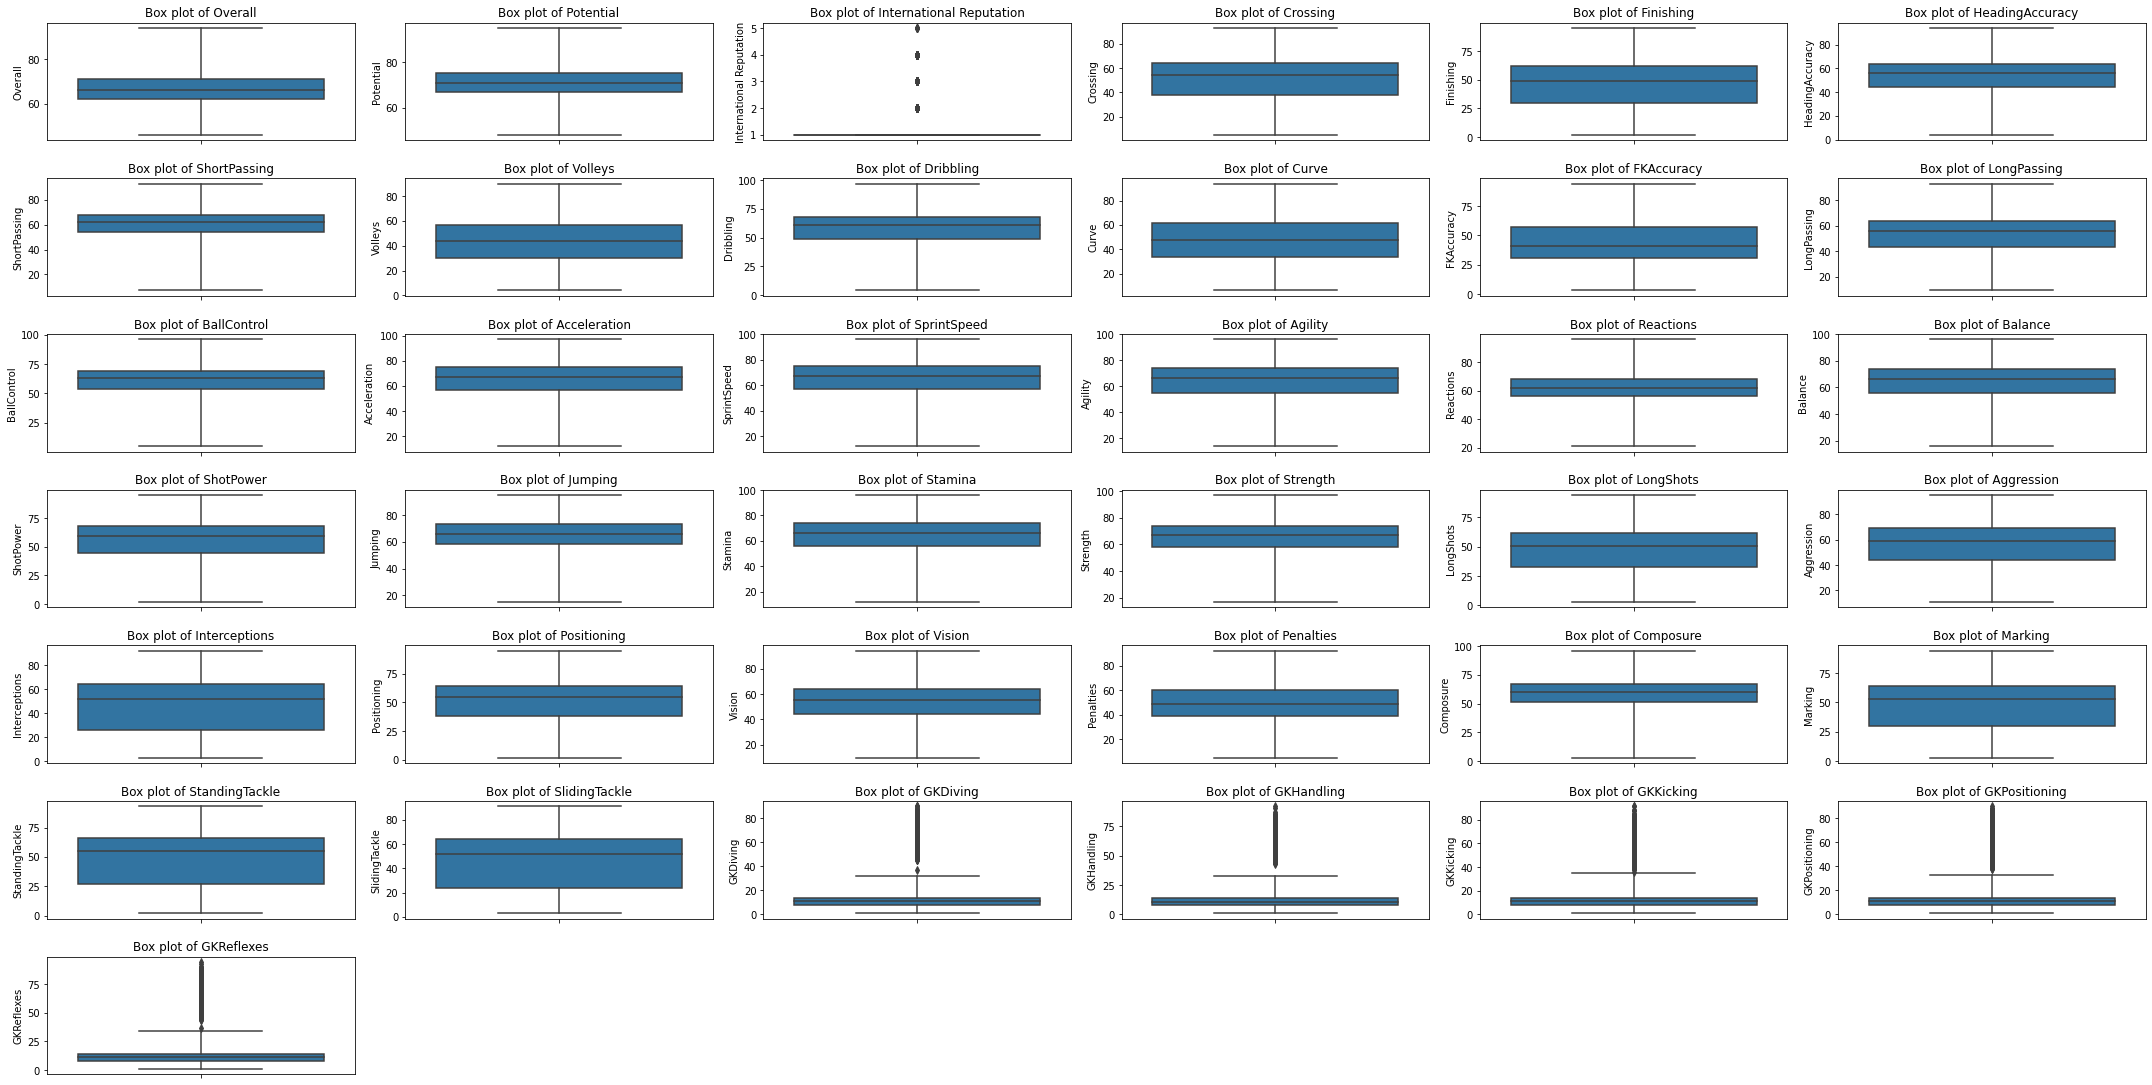

In [13]:
df_boxplot = pd.DataFrame()
df_boxplot = soccer_df.drop(['Name', 'Age', 'Club', 'Value', 'Wage', 'Position', 'Height', 'Weight'], axis=1)
df_boxplot.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize= (30, 80))
for i, col in enumerate(df_boxplot.columns): 
  plt.subplot(len(df_boxplot.columns), 6, i+1)
  sns.boxplot(y = df_boxplot[col], whis=3.5)
  plt.xticks(rotation='vertical')
  plt.title('Box plot of {}'.format(col))
plt.tight_layout()
plt.show()


### 3 - Who are the best 10 players and what is their position?

The statistics for the skills of each player are taken into account to provide an overall score (variable 'Overall') for each of them. That score determines how good a player is, its value and how sought after he will be by other clubs and for fantasy soccer fans. Let's first have a look at the distribution of the outcome, the variable 'Overall' score. We can see that the distribution is slightly skewed to the right, as we would expect that most professional players should have higher overall scores than lower ones.

<Figure size 576x360 with 0 Axes>

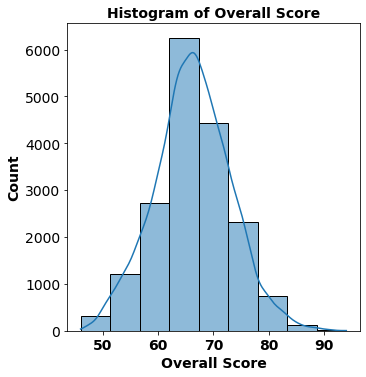

Skew of the distribution is 0.06294806520950566
Kurtosis of the distribution is 0.0951354041786927


In [14]:
bin_number= np.linspace(soccer_df.Overall.min(), soccer_df.Overall.max(), 10)

plt.figure(figsize=(8,5))
sns.displot(soccer_df.Overall, bins= bin_number, kde=True, facet_kws={'despine':False})
plt.xticks(fontweight='bold')
plt.tick_params(axis= 'both', which='major', labelsize=14)
plt.xlabel('Overall Score', fontweight='bold', fontsize=14)
plt.ylabel('Count', fontweight='bold', fontsize=14)
plt.title('Histogram of Overall Score', fontweight='bold', fontsize=14)
plt.show()

print('Skew of the distribution is', soccer_df['Overall'].skew())
print('Kurtosis of the distribution is', soccer_df['Overall'].kurt())


Now let's have a look at the top 10 players with the best overall scores. Lionel Messi and Cristiano Ronaldo have the best overall score, not very surprising for those who follow soccer as these are 2 great soccer players. All these players are playing at diverse positions, implying that the best players are not solely in the position of forward or goalkeeper.

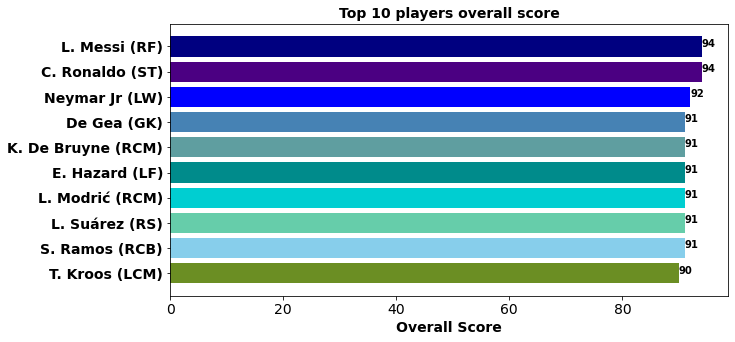

In [15]:
fig, axis = plt.subplots(figsize=(10,5))
plt.barh(soccer_df.sort_values(by='Overall', ascending=True)[-10:].Name, soccer_df.sort_values(by='Overall', ascending=True)[-10:].Overall,
         color=['olivedrab', 'skyblue', 'mediumaquamarine', 'darkturquoise', 'darkcyan', 'cadetblue', 'steelblue', 'blue', 'indigo', 'navy'])
for index, value in enumerate(soccer_df.sort_values(by='Overall', ascending=True)[-10:].Overall):
    plt.text(value, index, str(value), fontdict={'fontweight':'bold'})

labels = [item.get_text() for item in axis.get_yticklabels()]
labels[0] = 'T. Kroos (LCM)'
labels[1] = 'S. Ramos (RCB)'
labels[2] = 'L. Suárez (RS)'
labels[3] = 'L. Modrić (RCM)'
labels[4] = 'E. Hazard (LF)'
labels[5] = 'K. De Bruyne (RCM)'
labels[6] = 'De Gea (GK)'
labels[7] = 'Neymar Jr (LW)'
labels[8] = 'C. Ronaldo (ST)'
labels[9] = 'L. Messi (RF)'

axis.set_yticklabels(labels)

axis.tick_params(axis= 'both', which='major', labelsize=14)
plt.yticks(fontweight='bold')
plt.ylabel('')
plt.xlabel('Overall Score', fontweight='bold', fontsize=14)
plt.title('Top 10 players overall score', fontweight='bold', fontsize=14)

plt.show()



### 4 - Unsupervised Machine Learning: Clustering Techniques
In this section, I will investigate how clustering techniques can help identify the top tiers players for each position: forward, midfielder, defender and goalkeeper. I create a dataframe for each position and for the clustering approaches, I will only focus on the **forward** dataframe. The reason being, forward is the most important position in a soccer game because players in the forward position are the ones changing the course of the game by scoring against the opposite team to win the match. Moreover, they are the players that attract the most attention of the public due to their important role in defining the score of a macth. They are also usually the best paid.

The players are chosen based on their performance relative to their peers in the same position. Meaning that we cannot compare a defender to an attacker. I have to create various dataframes regrouping all the players with the same position, before training my models.

The main positions in soccer are: 
- Forward: Striker, Center Forward, Wingers. Acronyms: 'ST', 'LS', 'RS', 'CF', 'LF', 'RF', 'LW', 'RW'.
- Midfielder: Left Mid, Right Mid, Center Mid, Attacking Mid, Defensive Mid. Acronyms: 'LM', 'RM', 'CM', 'LCM', 'RCM', 'CAM', 'LAM', 'RAM', 'CDM', 'LDM', 'RDM'.
- Defender: Center back, Full Back (Left Back, Right Back), Wing Backs, Sweeper (RARE). Acronyms: 'CB', 'LB', 'RB', 'LWB', 'RWB', 'LCB', 'RCB'. Last 2 are sweepers.
- Goalkeeper. Acronyms: 'GK'

| FIFA positions | Acronymns |  | FIFA positions | Acronymns |
|----------|----:------|----------|------|------|
|	Goalkeeper | 'GK'| |	Striker | 'ST' |
|	Right Wing | 'RW' | |	Right Striker | 'RS' |
|	Left Wing | 'LW' | |	Left Striker | 'LS' |
| Right Back | 'RB' | |	Right Forward | 'RF' |
| Center Back | 'CB' | |	Center Forward |'CF' |
| Left Back | 'LB' | |	Left Forward | 'LF' |
| Right Wing Back | 'RWB' | |	Right Center Back | 'RCB' |
| Left Wing Back | 'LWB' | |	Left Center Back | 'LCB' |
| Center Defensive Midfielder | 'CDM' | |	Center Attacking Midfielder | 'CAM' |
|	Right Defensive Midfielder | 'RDM' | |	Right Attacking Midfielder | 'RAM' |
|	Left Defensive Midfielder | 'LDM' | |	Left Attacking Midfielder | 'LAM' |
|	Right Center Midfielder | 'RCM' | |	Right Midfielder | 'RM' | 
|	Left Center Midfielder | 'LCM' | |	Left Midfielder | 'LM' | 
| Center Midfielder | 'CM' | | | |



















In [16]:
forward_df = pd.DataFrame()
forward_df = soccer_df.loc[soccer_df.Position.isin(['ST', 'LS', 'RS', 'CF', 'LF', 'RF', 'LW', 'RW']), :].copy()
forward_df.reset_index(drop=True, inplace=True)

midfielder_df = pd.DataFrame()
midfielder_df = soccer_df.loc[soccer_df.Position.isin(['LM', 'RM', 'CM', 'LCM', 'RCM', 'CAM', 'LAM', 'RAM', 'CDM', 'LDM', 'RDM']), :].copy()
midfielder_df.reset_index(drop=True, inplace=True)

defender_df = pd.DataFrame()
defender_df = soccer_df.loc[soccer_df.Position.isin(['CB', 'LB', 'RB', 'LWB', 'RWB', 'LCB', 'RCB']), :].copy()
defender_df.reset_index(drop=True, inplace=True)

goalkeeper_df = pd.DataFrame()
goalkeeper_df = soccer_df.loc[soccer_df.Position.isin(['GK']), :].copy()
goalkeeper_df.reset_index(drop=True, inplace=True)



#### 4.1 - Correlation between features and outcome
There is some high correlation (greater than 0.8) between the outcome 'Overall' score and few features such as composure, positioning, shotpower, reactions, ball control, dribbling, shortpassing and finishing. I hope that this will somehow help the clustering algorithms.

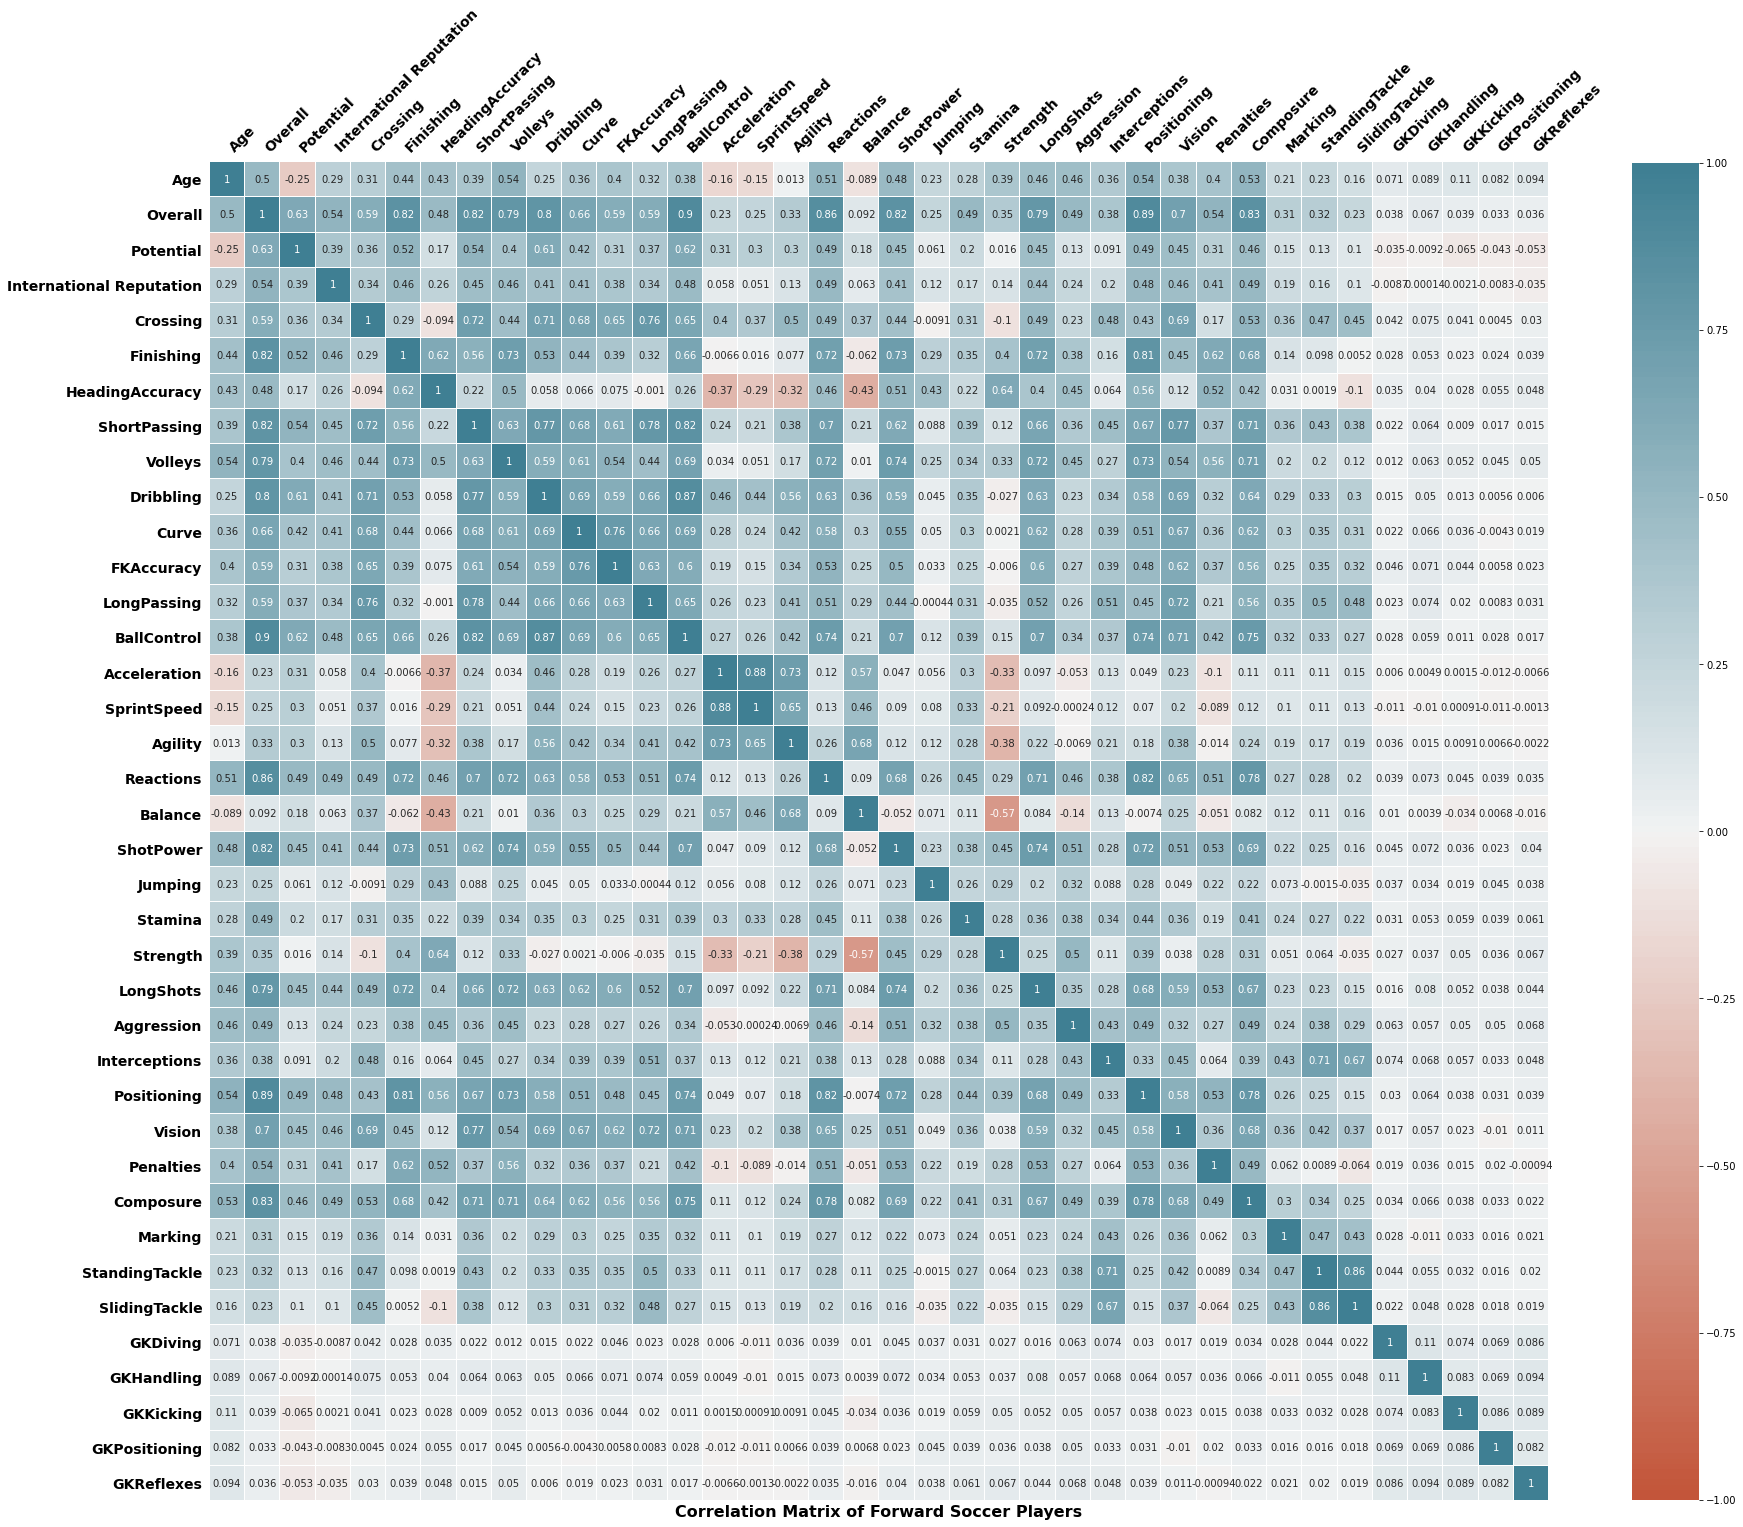

In [17]:
plt.figure(figsize=(30,30))
ax = sns.heatmap(forward_df.corr(), vmin = -1, vmax=1, center=0, annot = True, square=True, cmap=sns.diverging_palette(20,220,n=200), linewidth=.005, cbar_kws={"shrink": .82})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='left')
ax.set_xlabel('Correlation Matrix of Forward Soccer Players', fontweight='bold', fontsize=16)
ax.tick_params(axis= 'both', which='major', labelsize=14, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.savefig('forward_corr.png')
plt.show()


Let's work on the dataframe forward_df.

In [18]:
X_forward = forward_df.drop(['Name', 'Age', 'Overall', 'Potential', 'Club', 'Value', 'Wage', 'Position', 'Height', 'Weight'], axis=1)
y_forward = forward_df.Overall

# Standardize. All scores are from 1 to 99, but international reputation is from 1 to 5
scaler = StandardScaler()
X_forward_std = scaler.fit_transform(X_forward)


#### 4.2 - Dimensionality reduction
We have 35 features in our data. In order to visualize them and to limit the dimensions in the data without loosing the statistical powers of our models, I will perform dimensionality reduction. I will use 2 main methods: PCA (Principal Component Analysis) and UMAP (Uniform Manifold Approximation and Projection).


##### PCA
Let's first try PCA which is useful to find a low-dimensional representation of the high-dimensional data by retaining as much variation or information in the data as possible. It is clear from below that PCA cannot distinguish any class or group in the data. I will only use 2 components for PCA in order to visualize the data.

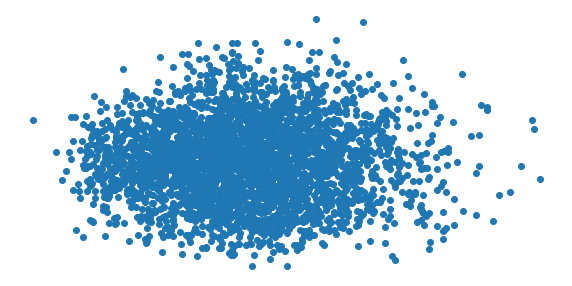

In [19]:
pca = PCA(n_components= 2, random_state=145)

pca.fit(X_forward_std)
pca_components = pca.transform(X_forward_std)


plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


##### UMAP
Let's now try UMAP which is a fast dimensionality reduction technique that can be used not only for visualization, but also for feature engineering when a need for reducing the dimensions arises. It does a pretty good job at preserving the local similarity as well as the global structure in the data. UMAP has some key parameters to tune in order to achieve the best separation of the data into regions. I am varying n_components, n_neighbors, min_dist and metric and making some plots below to get the best parameters. The final results will be used as input to the unsupervised learning models in a later section.

- Varying n_component

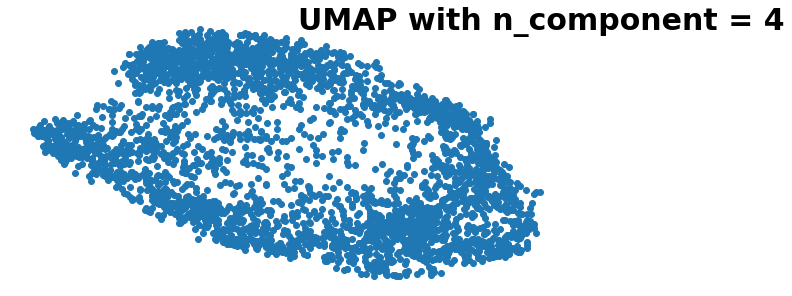

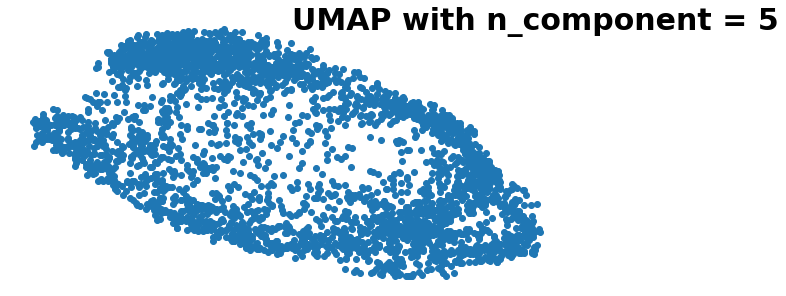

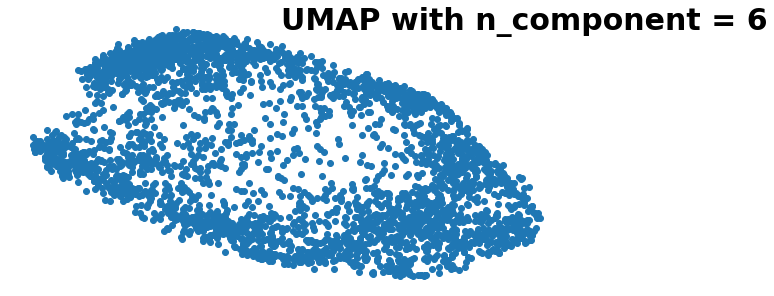

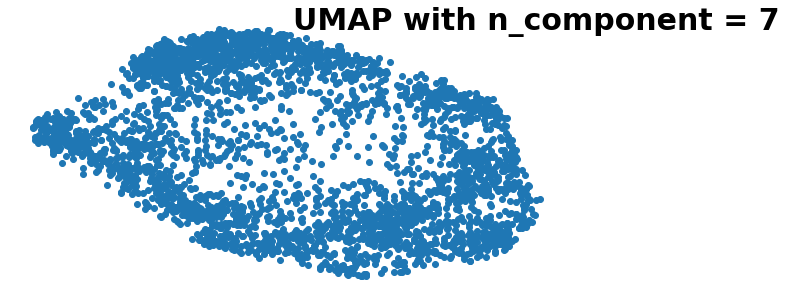

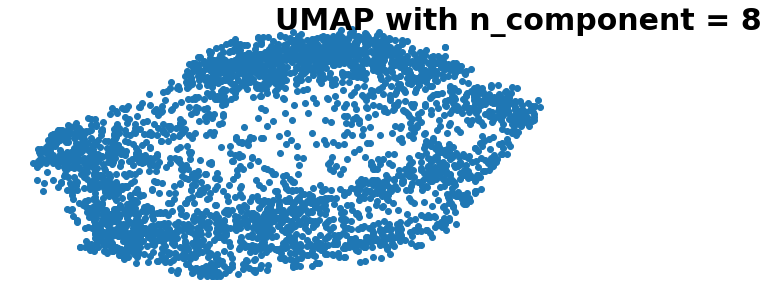

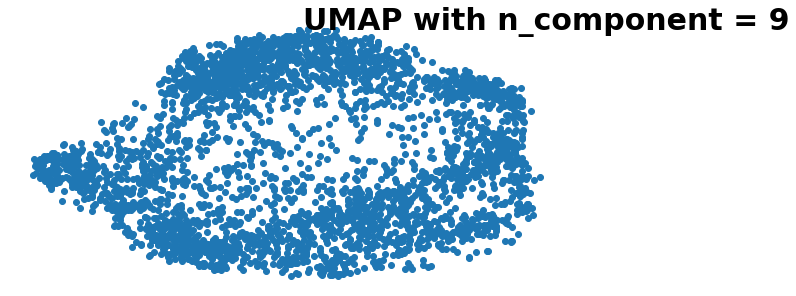

In [20]:
component_list = [4,5,6,7,8,9] 

for i,component in enumerate(component_list):
  umap_results = UMAP(n_components=component, metric='cosine', random_state=145).fit_transform(X_forward_std)

  plt.figure(figsize=(10,5))
  plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "UMAP with n_component = {}".format(component),
           fontdict={'weight': 'bold', 'size': 30})
  plt.scatter(umap_results[:,0], umap_results[:,1])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()




- Varying n_neighbors

After tuning min_dist and metric, and plotting different values of n_components with different values of n_neighbors, I settled on n_components=6 as the most acceptable value. By varying n_neighbors below, the value of 3 gave me the best separation I could achieve given my data.

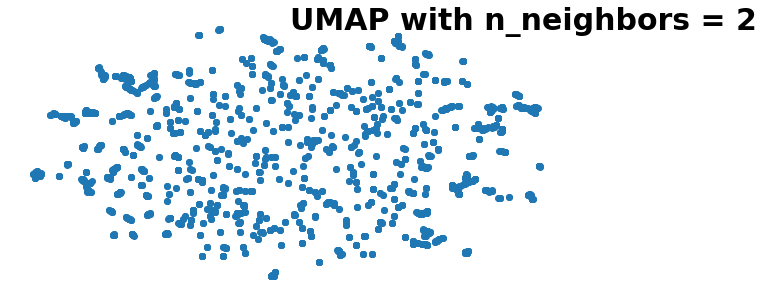

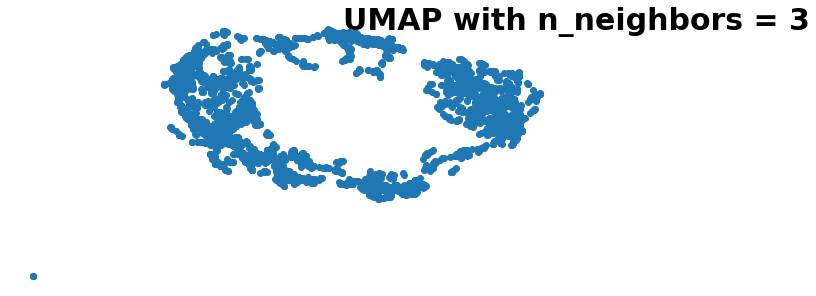

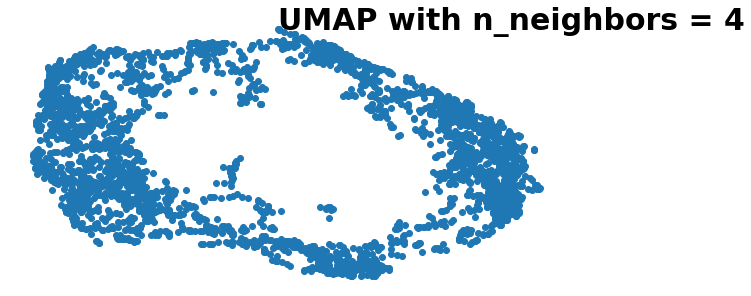

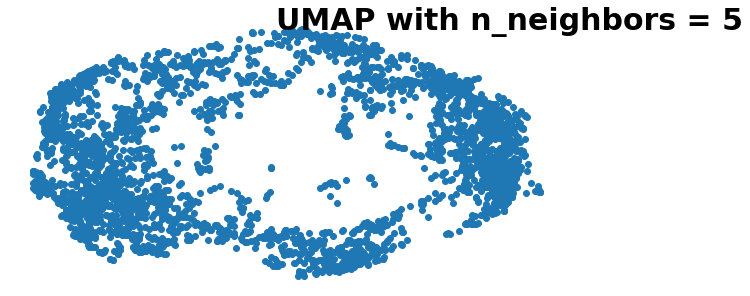

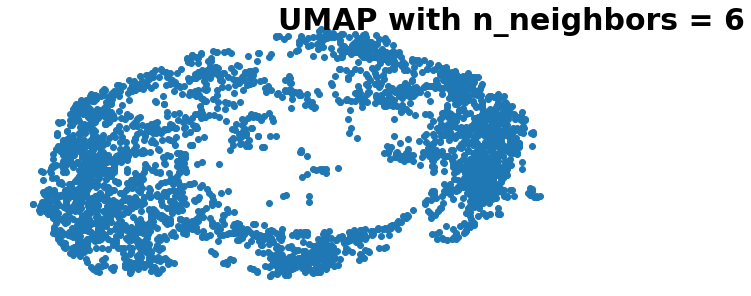

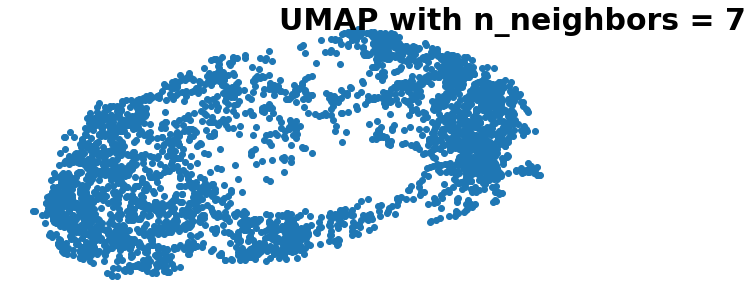

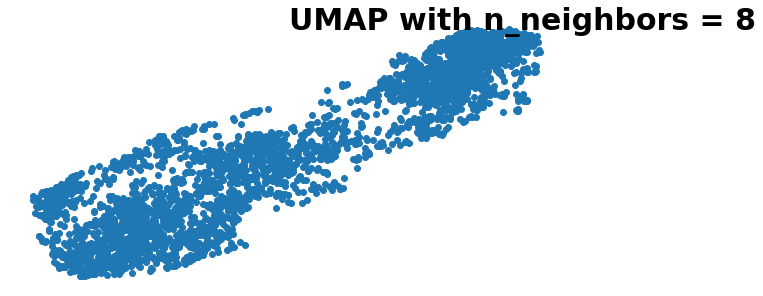

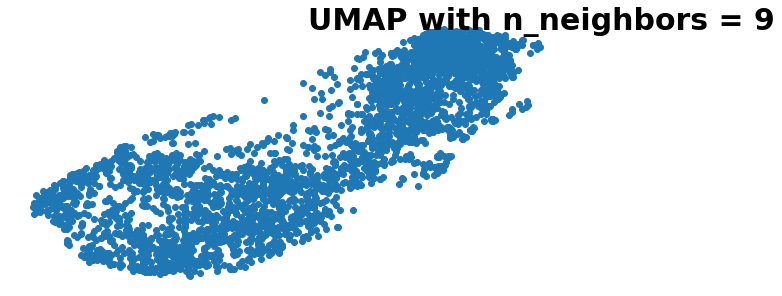

In [21]:
neighbors_list = [2,3,4,5,6,7,8,9] 
for i,neighbor in enumerate(neighbors_list):
  umap_results = UMAP(n_components=6, n_neighbors=neighbor, min_dist=.01, metric='cosine', random_state=145).fit_transform(X_forward_std) 

  plt.figure(figsize=(10,5))
  plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "UMAP with n_neighbors = {}".format(neighbor),
           fontdict={'weight': 'bold', 'size': 30})
  plt.scatter(umap_results[:,0], umap_results[:,1])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()




By using the dimensonality techniques above PCA and UMAP, I found that UMAP with parameters **n_components=6, n_neighbors=3, min_dist=.01 and metric='cosine'** achieved the most acceptable separation of my data into 4 regions. There are few points (3 to be exact) that are outliers. This is due to the fact that when projecting data from 35 dimensions into 6 dimensions, those 3 data points displayed different and strange characteristics compared to other points and thus became outliers, even though they were not in the original 35-dimension. 

Below I am going to investigate how much those outliers affect the silhouette score and see if I can discard them. I will run a quick test using K-Means, a clustering technique, which will be fully explained in a later section.

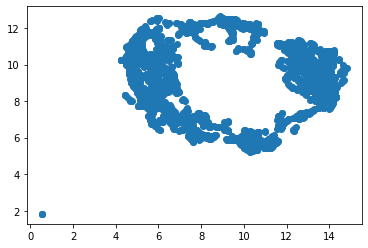

Cluster 2: Silhouette score = 0.5148450136184692 and standard deviation = 0.18630537390708923
Cluster 3: Silhouette score = 0.47663041949272156 and standard deviation = 0.17050139605998993
Cluster 4: Silhouette score = 0.5191049575805664 and standard deviation = 0.17460940778255463
Cluster 5: Silhouette score = 0.48715639114379883 and standard deviation = 0.18844294548034668
Cluster 6: Silhouette score = 0.47538623213768005 and standard deviation = 0.18996787071228027


In [22]:
umap_reducer = UMAP(n_components=6, n_neighbors=3, min_dist=.01, metric='cosine', random_state=145).fit(X_forward_std) 
umap_results = umap_reducer.transform(X_forward_std)

plt.scatter(umap_results[:,0], umap_results[:,1])
plt.show()

for i in range(2, 7):
  # Get the predicted clusters
  y_pred = KMeans(n_clusters= i, random_state= 145).fit_predict(umap_results)
  print('Cluster {}: Silhouette score = {} and standard deviation = {}'.format(i, metrics.silhouette_score(umap_results, y_pred, metric= 'euclidean', random_state=145),
                                                                np.std(metrics.silhouette_samples(umap_results, y_pred, metric='euclidean'))))


(array([1285, 2130, 2416]),)
[[0.5492081 0.5492003 0.5492219]]
[[1.8218788 1.8218769 1.8218977]]


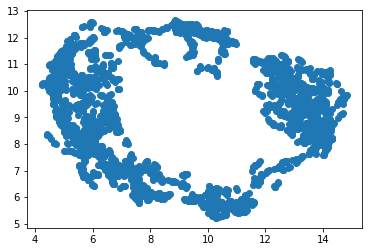

Cluster 2: Silhouette score = 0.5156036615371704 and standard deviation = 0.1867266595363617
Cluster 3: Silhouette score = 0.4766490161418915 and standard deviation = 0.1692286729812622
Cluster 4: Silhouette score = 0.5203913450241089 and standard deviation = 0.17309267818927765
Cluster 5: Silhouette score = 0.4888243079185486 and standard deviation = 0.18546338379383087
Cluster 6: Silhouette score = 0.47732535004615784 and standard deviation = 0.1872517466545105


In [23]:
umap_reducer = UMAP(n_components=6, n_neighbors=3, min_dist=.01, metric='cosine', random_state=145).fit(X_forward_std)
umap_results_all = umap_reducer.transform(X_forward_std)

index_outliers = np.where((umap_results_all[:,0] < 6) & (umap_results_all[:,1] < 6))
print(index_outliers)
print(umap_results_all[index_outliers,0])
print(umap_results_all[index_outliers,1])

# Delete the 3 points and plot to show that there are no more outliers. Also delete them for the forward_df and reset indices
umap_results = np.delete(umap_results_all, (index_outliers), axis=0)

forward_df_nooutliers = forward_df.drop(index_outliers[0]) 
forward_df_nooutliers.reset_index(drop=True, inplace=True)

plt.scatter(umap_results[:,0], umap_results[:,1])
plt.show()

# Let's have a quick check at the performance metrics of one clustering technique (K-Means), just to see if any significant effect of deleting outliers on silhouette score.
for i in range(2, 7):
  # Get the predicted clusters
  y_pred = KMeans(n_clusters= i, random_state= 145).fit_predict(umap_results)
  print('Cluster {}: Silhouette score = {} and standard deviation = {}'.format(i, metrics.silhouette_score(umap_results, y_pred, metric= 'euclidean', random_state=145),
                                                                np.std(metrics.silhouette_samples(umap_results, y_pred, metric='euclidean'))))


You can see from above that there is not much difference in silhouette score between the clusters with and without the 3 outliers. However, the visualization of clusters is better and I will proceed with the umap_results without outliers.

Because UMAP is also a feature engineering technique, I will use the dimensionally reduced data (which now have 6 components) obtained with the parameters above (**n_components=6, n_neighbors=3, min_dist=.01 and metric='cosine'**), as input to the clustering techniques below to identify patterns/top-tiers of soccer athletes playing in the 'forward' position. Let me mention that I tested all clustering techniques below with all the 35 features as input and the algorithms were not able to identify clusters of players. Hence the use of UMAP feature engineering.

#### 4.3 - Clustering Techniques

##### 4.3.1 - K-means clustering
For k-means, determing the optimal k is extremely important. To determine a good starting k, I have applied the Elbow method. The Elbow method is a popular technique where the idea is to run k-means clustering for a range of clusters k and for each value, calculate the sum of squared distances from each point to its assigned center (or distortions). If we plot the distortions, the resulting graph will look like an arm, where the 'elbow' is the best value of k.

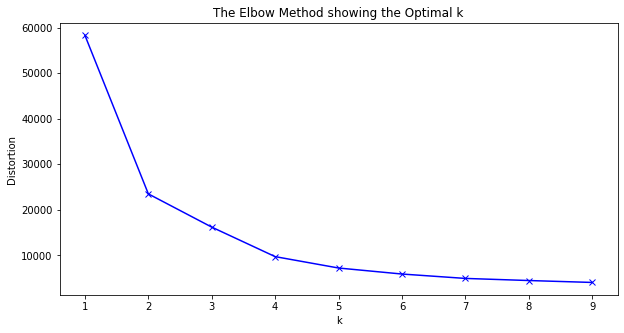

In [24]:
# Running K-Means with a range of k
distortions = []
K = range(1,10)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(umap_results)
  distortions.append(kmeanModel.inertia_)

# Plotting the distortions of K-Means
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the Optimal k')
plt.show()

From the graph, we can observe that the 'elbow' is at k = 2. Now we can start a K-Means algorithm using n_clusters = 2.

In [25]:
# Defining the k-means
cluster_numbers_forward = [2, 3, 4, 5, 6, 7, 8, 9]
y_forward_pred = [] # y Predictions

for i in cluster_numbers_forward:
  k_means_forward = KMeans(n_clusters=i, random_state=145, n_jobs=-1)
  y_forward_pred.append(k_means_forward.fit_predict(umap_results)) 



Plotting the data below (with and without colours), we can see that the best identification patterns are for 4 clusters, we have 4 top tiers of players. The 6 components in UMAP reduced matrix retained a significant amount of information in the data, which allowed for clusters' identification.

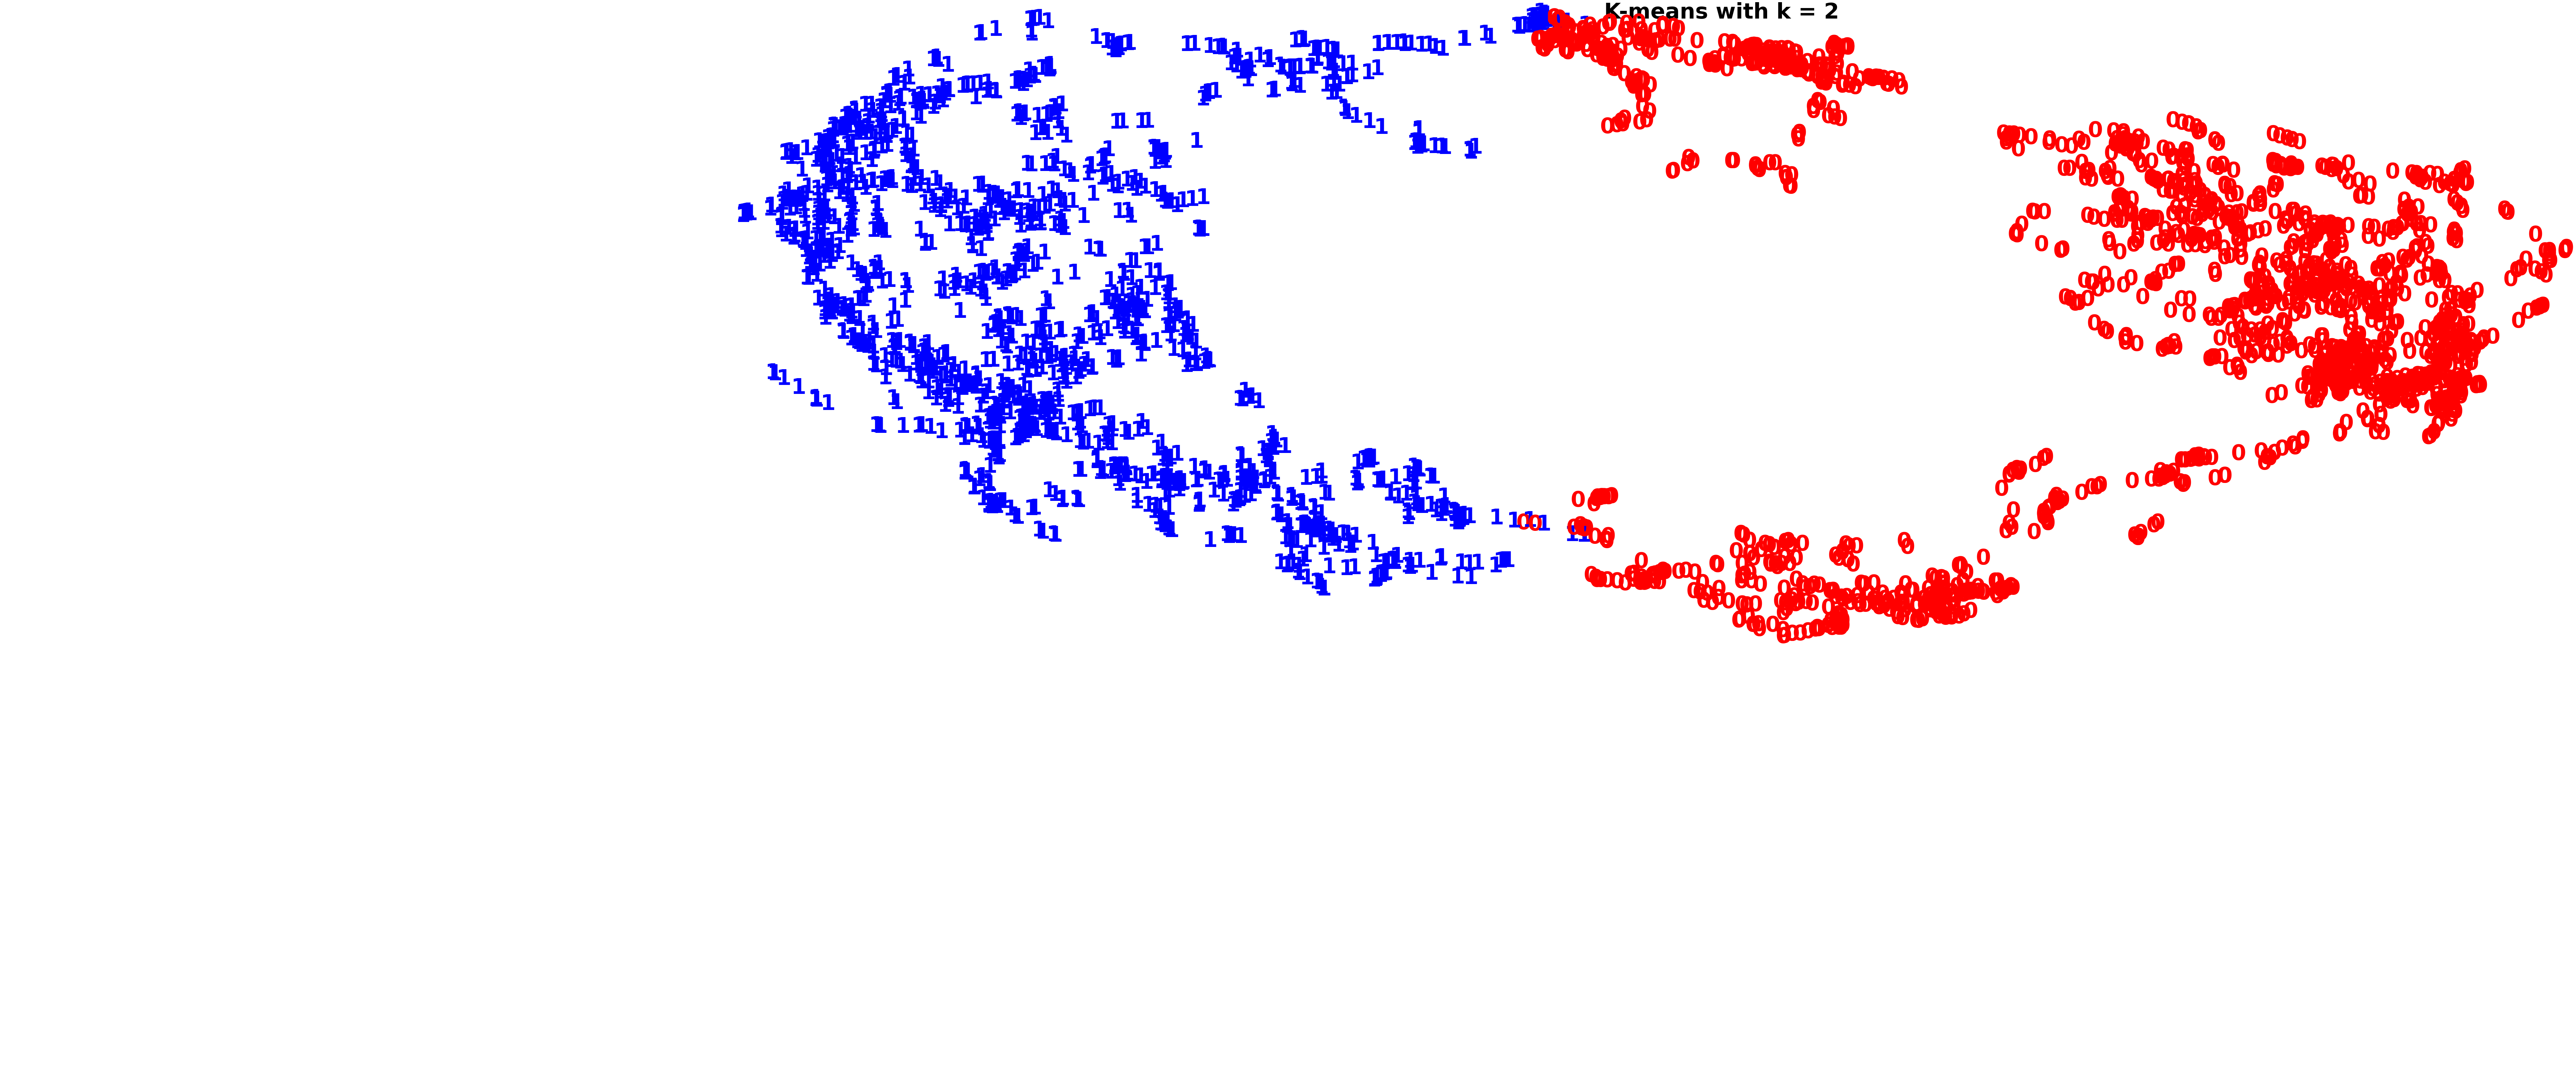

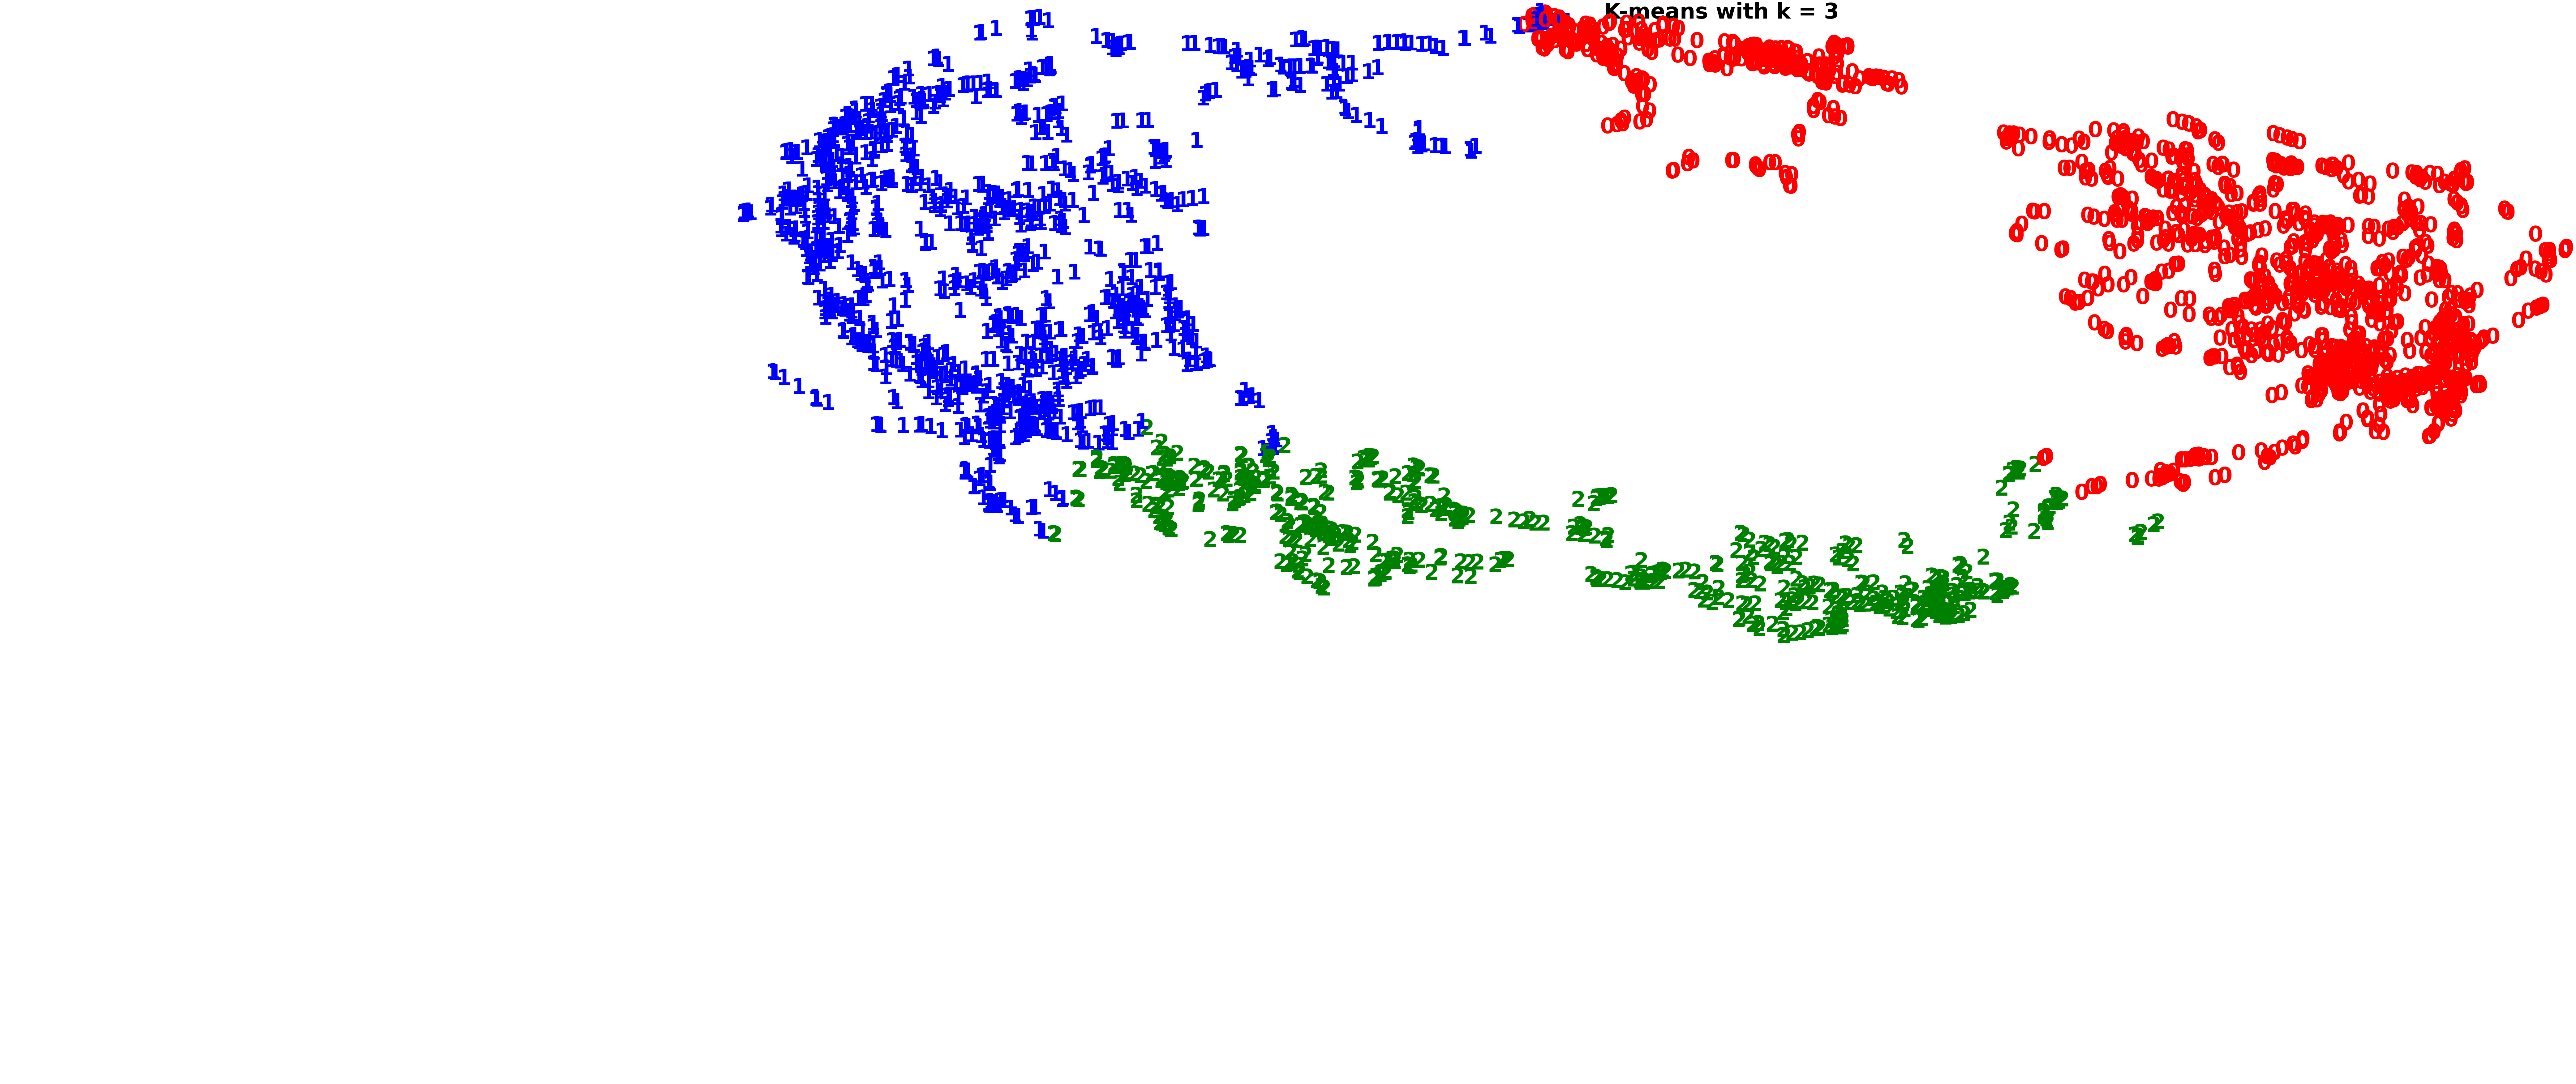

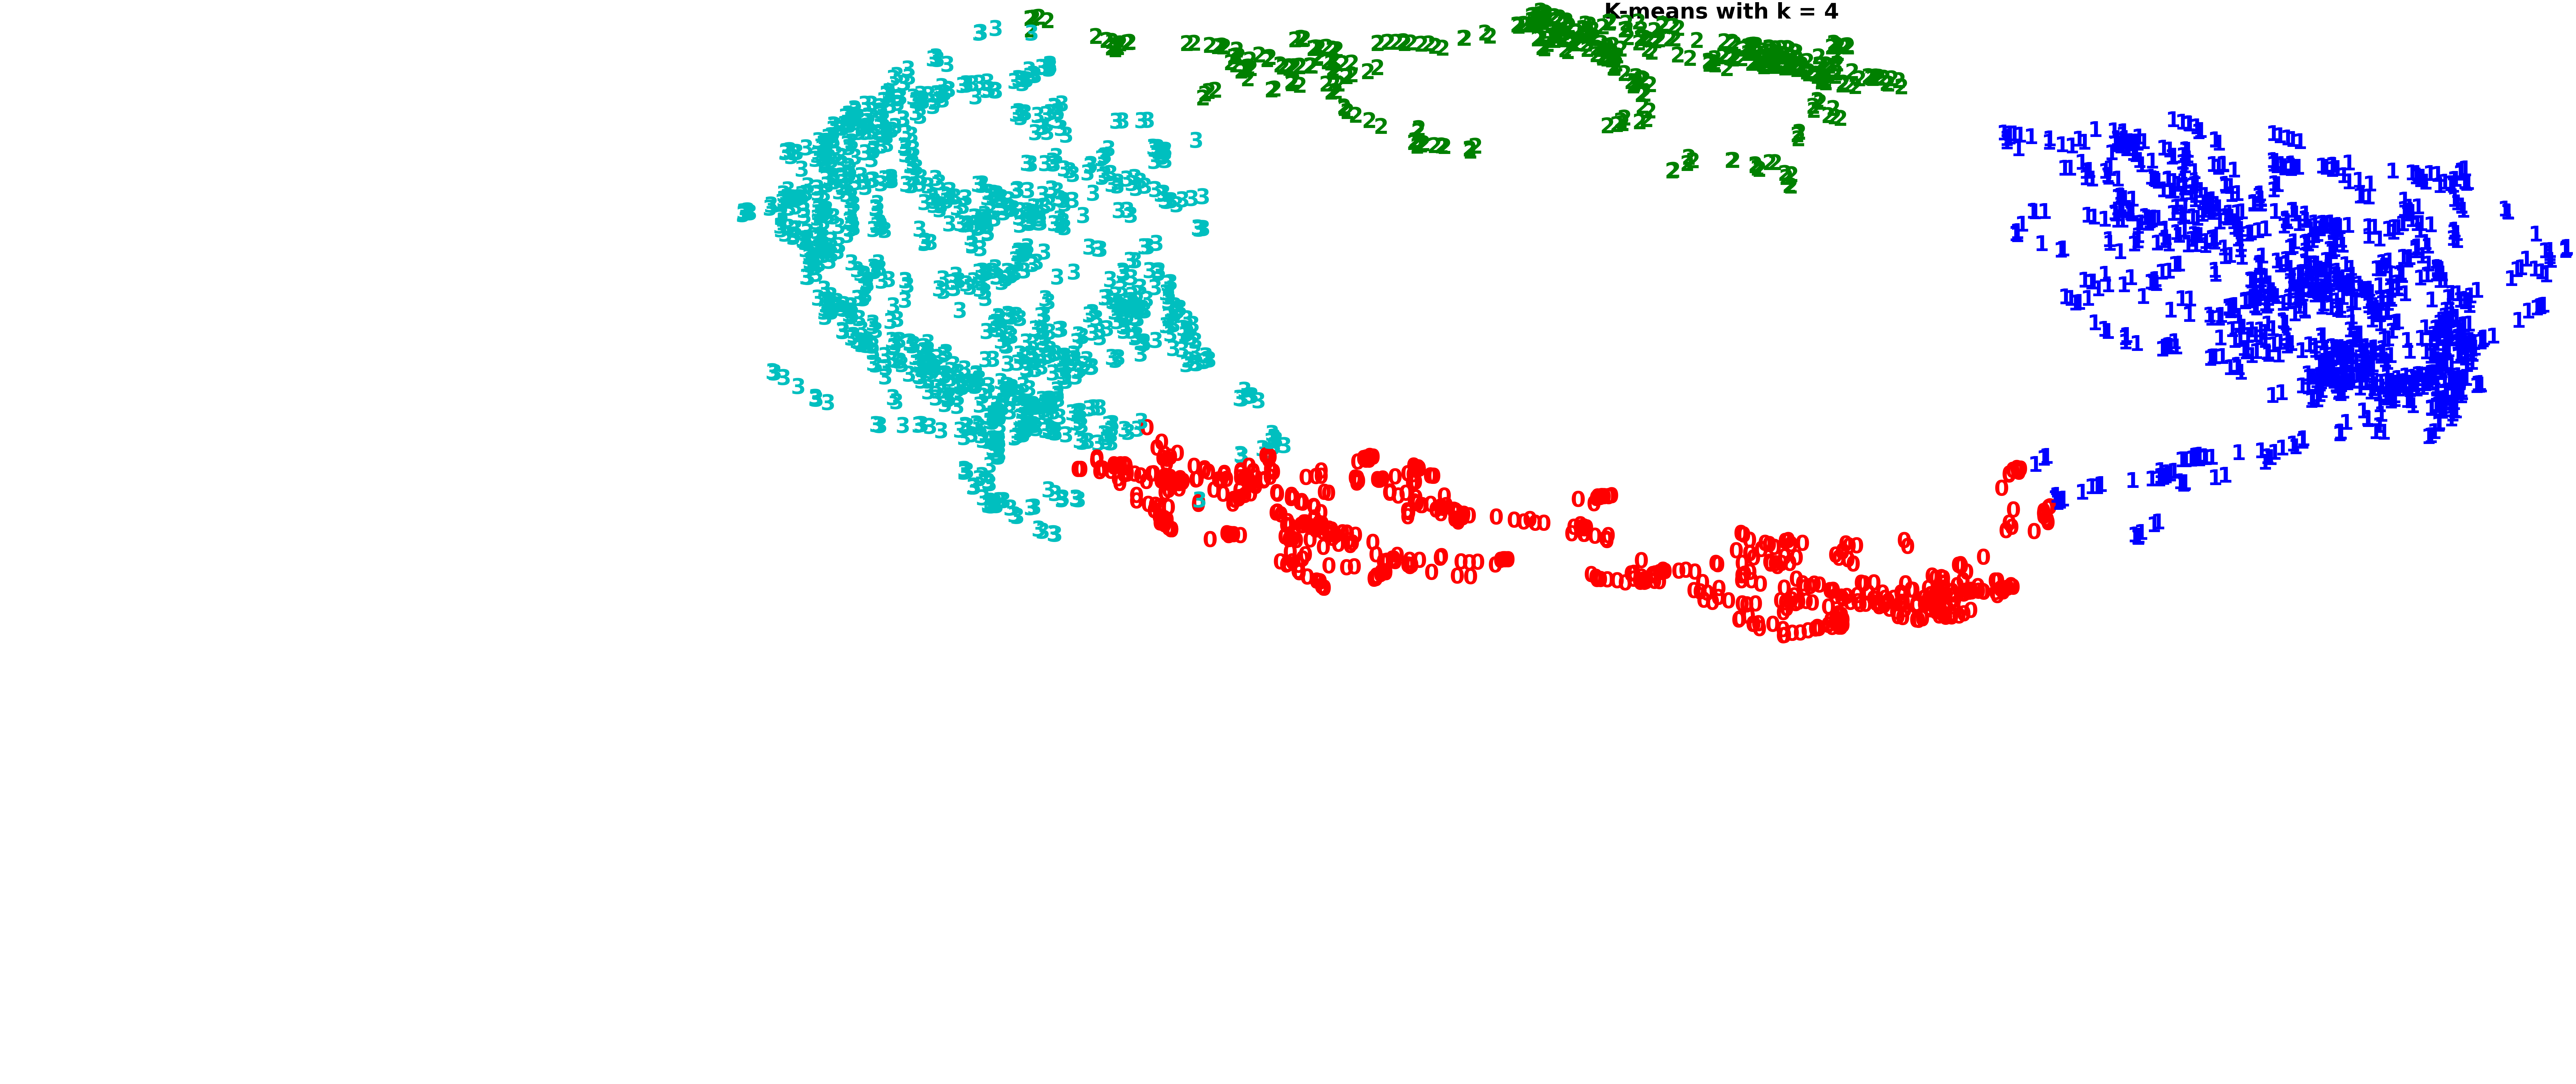

In [ ]:
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"] 
for i, solution in enumerate(y_forward_pred):
    plt.figure(figsize=(10,5))
    plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "K-means with k = {}".format(cluster_numbers_forward[i]), 
                 fontdict={'weight': 'bold', 'size': 70})
    for i in range(umap_results.shape[0]):
      plt.text(umap_results[i, 0], umap_results[i, 1], str(solution[i]), 
               color=colours[solution[i]],
               fontdict={'weight': 'bold', 'size': 70}
            )
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()



In [ ]:
# With no colours
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"] 
for i, solution in enumerate(y_forward_pred):
    plt.figure(figsize=(10,5))
    plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "K-means with k = {}".format(cluster_numbers_forward[i]), 
                 fontdict={'weight': 'bold', 'size': 70})
    for i in range(umap_results.shape[0]):
      plt.text(umap_results[i, 0], umap_results[i, 1], str(solution[i]), 
               fontdict={'weight': 'bold', 'size': 70}
            )
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()



When it comes to choosing the number of clusters and the clustering algorithm, we need to measure consistency across sub-samples or folds. Clusters are useful when similar data points get grouped together each time the algorithm is run on different subsets of the same data. However, there's no formal metric for assessing how "similar" clusters are between different data subsets.

To explore this consistency issue, I'll compare two-, three-, four- and five-cluster solutions for my *forward* dataset. I'll still be using k-means algorithm and dividing the data into two samples of equal size. The goal here will be to determine which k value optimizes consistency across the two samples.

In [ ]:
# Define X_pca by removing outliers that were identified from UMAP.
X_pca = np.delete(pca_components, (index_outliers), axis=0)

# Split the data into four equally-sized samples. First break it in half:
# X_half1, X_half2, pca_half1, pca_half2 = train_test_split(umap_results_all, pca_components, test_size=0.5, random_state=145)
X_half1, X_half2, pca_half1, pca_half2 = train_test_split(umap_results, X_pca, test_size=0.5, random_state=145)

# I have an odd number of data, so after splitting the data, I will remove the extra data point (last point) from the larger array.
# Use loop for below in case size of array changes. Because I have an odd number of samples, the splitting will always give me new array of different sizes.
if ((X_half1.shape[0] > X_half2.shape[0]) & (pca_half1.shape[0] > pca_half2.shape[0])):
  X_half1 = X_half1[:-1,:]
  pca_half1 = pca_half1[:-1,:]
elif ((X_half1.shape[0] < X_half2.shape[0]) & (pca_half1.shape[0] < pca_half2.shape[0])):
  X_half2 = X_half2[:-1,:]
  pca_half2 = pca_half2[:-1,:]

# Dataframe to store features and predicted cluster memberships:
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, pca_half1),
    (X_half2, pca_half2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 5.
    for nclust in range(2, 6):
        pred = KMeans(n_clusters=nclust, random_state=145).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [ ]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Observing the visualizations (and ignoring the coloring), it appears that all cluster solutions are consistent across the subsamples. However, we can't rely solely on visualizations, as they can be misleading. That's why looking at quantitative ways of evaluating the clustering algorithm is very important, hence the use of silhouette score below.

I do not have existing labels in my data, meaning that I do not have established patterns or clusters in my data. I am relying on the clustering techniques to identify them. In such case, the best metric to evaluate my model performance is the Silhouette score. The Silhouette score for 4 clusters is the highest and for 2 clusters is very similar. Moreover, visually K-means with 4 clusters performs better. That will be the K-means clustering result I will retain. 

I am also showing the standard deviation of the silhouette samples to look at the spread of the silhouette values. The standard deviations are fairly consistent across all clusters, meaning that the clusters deviate very little from their mean independently of the number of clusters I choose. This suggests that K-means found stable clusters and thus stable solutions, which is exactly what we want.

In [ ]:
for i in range(2, 10):
  # Get the predicted clusters
  y_pred = KMeans(n_clusters= i, random_state= 145).fit_predict(umap_results)
  print('Cluster {}: Silhouette score = {} and standard deviation = {}'.format(i, metrics.silhouette_score(umap_results, y_pred, metric= 'euclidean', random_state=145),
                                                                np.std(metrics.silhouette_samples(umap_results, y_pred, metric='euclidean'))))


The top 4 tiers are obtained with K-means with 4 clusters. The top 10 players who belong to each of those clusters are shown in the following table.

|Cluster|Player|Overall Score|Cluster|Player|Overall Score|Cluster|Player|Overall Score|Cluster|Player|Overall Score|
|----|------|-----|-----|-----|---|----|--|--|--|--|--|
| 0 | Daniel Candeias | 74 | 1 | J. Tagueu | 72 | 2 | B. Dost | 83 | 3 | L. Messi | 94 | 
| 0 | R. Quaison | 74 | 1| S. Bahoken | 72 | 2 | N. Petersen | 79 | 3 | Cristiano Ronaldo | 94 |
| 0 | M. Bolaños | 73 | 1 | Enric Gallego | 71 | 2 | Dyego Sousa | 78 | 3 | Neymar Jr | 92 |
| 0 | Cristiano | 73 | 1| S. Abdullahi | 71 | 2 | W. Weghorst | 78 | 3 | E. Hazard | 91 |
| 0 | Toni Villa | 73 | 1| J. Marriott | 71 | 2 | G. Hoarau | 77 | 3 | L. Suárez | 91 |
| 0 | G. Wikheim | 73 | 1 | B. Koita | 71 | 2 | Jorge Molina | 77 | 3 | R. Lewandowski | 90 |
| 0 | A. González | 72 | 1| G. Litteri | 71 | 2 | P. Cutrone | 77 | 3 | P. Dybala | 89 |
| 0 | Y. Orozco | 72 | 1 | B. Róchez' | 71 | 2 | A. Mitrović | 77 | 3 | H. Kane | 89 |
| 0 | Gao Lin | 72 | 1 | S. Maguire | 71 | 2 | E. Gigliotti | 77 | 3 | E. Cavani | 89 |
| 0 | R. Sallai | 72 | 1 | Lee Seung Woo | 70 | 2 | J. Augustin | 77 | 3 | S. Agüero | 89 | 
| 0 | Sebá | 72 | 1 | S. Ubilla | 70 | 2 | Júnior Moraes | 76 | 3 | L. Insigne | 88 |


The cluster number 3 has the best players from the entire dataframe of forward players, with the highest 'Overall' score.

In [ ]:
kmeans_clusters_fn = KMeans(n_clusters=4, random_state=145, n_jobs=-1)

# Fit the model
kmeans_clusters = kmeans_clusters_fn.fit_predict(umap_results)

name_index0, name_index1, name_index2, name_index3 = 0, 0, 0, 0
cluster_name = []
for i in range(umap_results.shape[0]):
  if ((kmeans_clusters[i] == 0) & (name_index0 <= 10)):
    list_dummy = [kmeans_clusters[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name.append(list_dummy)
    name_index0 += 1
  elif ((kmeans_clusters[i] == 1) & (name_index1 <= 10)):
    list_dummy = [kmeans_clusters[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name.append(list_dummy)
    name_index1 += 1
  elif ((kmeans_clusters[i] == 2) & (name_index2 <= 10)):
    list_dummy = [kmeans_clusters[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name.append(list_dummy)
    name_index2 += 1
  elif ((kmeans_clusters[i] == 3) & (name_index3 <= 10)):
    list_dummy = [kmeans_clusters[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name.append(list_dummy)
    name_index3 += 1
  else:
    var_end = 0



##### 4.3.2 - Hierarchical clustering
Let's try another clustering technique, hierarchical clustering that aims at building a tree-like hierarchy of clusters within the data called dendogram. I will use 3 different types of agglomerative clustering methods.

In [ ]:
# Defining the agglomerative clustering
agg_cluster_complete = AgglomerativeClustering(n_clusters=4, linkage= 'complete', affinity= 'euclidean')

# Fit the model
clusters_complete = agg_cluster_complete.fit_predict(umap_results)

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters_complete[i]),
             color=colours[clusters_complete[i]],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


In [ ]:
# Defining the agglomerative clustering
agg_cluster_average = AgglomerativeClustering(n_clusters=4, linkage= 'average', affinity= 'euclidean')

# Fit the model
clusters_average = agg_cluster_average.fit_predict(umap_results)

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters_average[i]),
             color=colours[clusters_average[i]],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()



In [ ]:
agg_cluster_ward = AgglomerativeClustering(n_clusters=4, linkage= 'ward', affinity= 'euclidean')

# Fit the model
clusters_ward = agg_cluster_ward.fit_predict(umap_results)

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"] 
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters_ward[i]),
             color=colours[clusters_ward[i]],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


In [ ]:
print("The Silhouette score and standard deviation of the Agglomerative Clustering solution for each of the linkage method: \n complete {} and {}, \n average {} and {}, \n ward {} and {}."
      .format(metrics.silhouette_score(umap_results, clusters_complete, metric='euclidean'), np.std(metrics.silhouette_samples(umap_results, clusters_complete, metric='euclidean')),
              metrics.silhouette_score(umap_results, clusters_average, metric='euclidean'), np.std(metrics.silhouette_samples(umap_results, clusters_average, metric='euclidean')),
              metrics.silhouette_score(umap_results, clusters_ward, metric='euclidean'), np.std(metrics.silhouette_samples(umap_results, clusters_ward, metric='euclidean'))))




All the agglomerative clustering methods perform very similarly, but lower than the K-means with 4 clusters. 

Let's have a look at their dendrograms

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(umap_results, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(umap_results, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(umap_results, method='ward'))
plt.show()

##### 4.3.3 - DBSCAN clustering
Let's try another clustering technique DBSCAN which can find clusters of any arbitrary shape.

In [ ]:
for i in [0.01,0.05,0.1,.2,.3,.4,.5,.6,.7,.8]:
  dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
  # Fit model
  clusters = dbscan_cluster.fit_predict(umap_results)
  print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))

  print('DBSCAN: Silhouette score = {} and standard deviation = {}'.format(metrics.silhouette_score(umap_results, clusters), np.std(metrics.silhouette_samples(umap_results, clusters))))
 
 

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10]:
  dbscan_cluster = DBSCAN(eps=0.1, min_samples=i, metric="euclidean")
  # Fit model
  clusters = dbscan_cluster.fit_predict(umap_results)
  print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

  print('DBSCAN: Silhouette score = {} and standard deviation = {}'.format(metrics.silhouette_score(umap_results, clusters), np.std(metrics.silhouette_samples(umap_results, clusters))))
 
 

In [ ]:
# Defining the agglomerative clustering. eps value from above
dbscan_cluster_3 = DBSCAN(eps= 0.1, min_samples= 1, metric= 'euclidean')

# Fit the model
cluster_3 = dbscan_cluster_3.fit_predict(umap_results)

print('DBSCAN: Silhouette score = {} and standard deviation = {}'.format(metrics.silhouette_score(umap_results, cluster_3), np.std(metrics.silhouette_samples(umap_results, cluster_3))))


We can see from the silhouette score that DBSCAN performs lower than K-means with 4 clusters.

In [ ]:
color_list = [] 
ctab_col = [cm.Set1.colors, cm.Set2.colors, cm.Set3.colors, cm.Dark2.colors, cm.tab10.colors, cm.tab20.colors, cm.tab20b.colors, cm.tab20c.colors] 
for i in ctab_col: 
  for j in i: 
    color_list.append(j) 

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(int(cluster_3[i])),
            #  color=color_list[int(cluster_3[i])],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()



##### 4.3.4 - Gaussian Mixture Models
This time, I will apply Gaussian Mixture Models (GMM) to identify the top tiers players. It is the only technique that uses soft clustering. The previous models all used hard clustering. For this model, we can assess the confidence by investigating the probabilities, and it can work with non-linear geometries.

This method aims to find the gaussian distributions for each cluster in the data. 

In [ ]:
covariance_list = ['full', 'tied', 'diag', 'spherical'] 
for k,covar_type in enumerate(covariance_list):
  clusters_gmm = GaussianMixture(n_components=3, covariance_type=covar_type, random_state= 145).fit_predict(umap_results)
  print('GMM with 3 components: Silhouette score = {} and standard deviation = {}'.format(metrics.silhouette_score(umap_results, clusters_gmm),
                                                                                           np.std(metrics.silhouette_samples(umap_results, clusters_gmm))))

  plt.figure(figsize=(10,5))
  colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
  plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "Gaussian Mixture with covariance_type = {}".format(covar_type),
           fontdict={'weight': 'bold', 'size': 70})

  for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters_gmm[i]),
             color=colours[clusters_gmm[i]], fontdict={'weight': 'bold', 'size': 70}
    )

  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()




In [ ]:
covariance_list = ['full', 'tied', 'diag', 'spherical'] 
for k,covar_type in enumerate(covariance_list):
  clusters_gmm = GaussianMixture(n_components=4, covariance_type=covar_type, random_state= 145).fit_predict(umap_results)
  print('GMM with 4 components: Silhouette score = {} and standard deviation = {}'.format(metrics.silhouette_score(umap_results, clusters_gmm),
                                                                                           np.std(metrics.silhouette_samples(umap_results, clusters_gmm))))

  plt.figure(figsize=(10,5))
  colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
  plt.text(np.mean(umap_results[:,0]), np.max(umap_results[:, 1]), "Gaussian Mixture with covariance_type = {}".format(covar_type),
           fontdict={'weight': 'bold', 'size': 70})

  for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], str(clusters_gmm[i]),
             color=colours[clusters_gmm[i]], fontdict={'weight': 'bold', 'size': 70}
    )

  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()


In [ ]:
# Compare to cluster_name
clusters_gmm = GaussianMixture(n_components=4, covariance_type='spherical', random_state= 145).fit_predict(umap_results)

name_index0, name_index1, name_index2, name_index3 = 0, 0, 0, 0
cluster_name_gmm = []
for i in range(umap_results.shape[0]):
  if ((clusters_gmm[i] == 0) & (name_index0 <= 10)):
    list_dummy = [clusters_gmm[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name_gmm.append(list_dummy)
    name_index0 += 1
  elif ((clusters_gmm[i] == 1) & (name_index1 <= 10)):
    list_dummy = [clusters_gmm[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name_gmm.append(list_dummy)
    name_index1 += 1
  elif ((clusters_gmm[i] == 2) & (name_index2 <= 10)):
    list_dummy = [clusters_gmm[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name_gmm.append(list_dummy)
    name_index2 += 1
  elif ((clusters_gmm[i] == 3) & (name_index3 <= 10)):
    list_dummy = [clusters_gmm[i], forward_df_nooutliers.Name[i], forward_df_nooutliers.Overall[i]]
    cluster_name_gmm.append(list_dummy)
    name_index3 += 1
  else:
    var_end = 0



GMM results with n_components = 4 and covariance_type='spherical' seem to be the best visually and in terms of Silhouette score. They do a better job compared to other parameters at identifying the top tiers players as does K-means clustering with 4 clusters.

### 5 - Conclusion and recommendations
Below is a summary of the score for the soccer players in the **forward** position.
The cluster visualization column is a subjective column based on my personal opinion of the visualization of the clusters. The mathematical metrics to evaluate each clustering technique is the Silhouette score.


| POSITION | MODEL | PARAMETERS | SILHOUETTE SCORE +/- STD | CLUSTER VISUALIZATION |
|----------|:------|:-----------|:-----------------|:-----|
| **Forward** | K-Means | k = 4 | 0.52 +/- 0.17 | Very Good |
|  | Hierarchical (Agglomerative) | linkage = complete, affinity = euclidean | 0.49 +/- 0.23 | Good |
| | | linkage = average, affinity = euclidean | 0.48 +/- 0.23 | Poor |
| | | linkage = ward, affinity = euclidean | 0.50 +/- 0.23 | Good |
| | DBSCAN | epsilon = .1, minPts = 1 | 0.48 +/- 0.31 | Poor |
| | Gaussian Mixture Models | components = 3, covariance_type='full' | 0.47 +/- 0.17 | Very Poor |
| | | components = 4, covariance_type='spherical' | 0.52 +/- 0.18 | Very Good |


I was able to perform adequate clustering of the soccer players playing in the **forward** position. K-Means with 4 clusters and Gaussian Mixture Models with 4 components and spherical covariance performed the best. They both had the highest silhouette score, smallest and consistent spread of silhouette samples and best cluster visualization.

The best **forward** players to pick for clubs or fantasy soccer fans, or to analyze the opposition teams, are obviously those with the highest 'Overall' score. But looking into the statistics of those best players (especially the top 5 with the highest 'Overall' score), it is important to look for forwards with a combination of high crossing, finishing, ball control, acceleration, reactions and composure.

Something that could be done later could be to maybe use original data with features specific to **forward** players, meaning excluding goalkeeping features, during clustering. And also potentially exploring other clustering techniques.
